# Human Protein Atlas - EDA

#### From the competition description

There are billions of humans on this earth, and each of us is made up of trillions of cells. Just like every individual is unique, even genetically identical twins, scientists observe differences between the genetically identical cells in our bodies.

Differences in the location of proteins can give rise to such cellular heterogeneity. Proteins play essential roles in virtually all cellular processes. Often, many different proteins come together at a specific location to perform a task, and the exact outcome of this task depends on which proteins are present. As you can imagine, different subcellular distributions of one protein can give rise to great functional heterogeneity between cells. Finding such differences, and figuring out how and why they occur, is important for understanding how cells function, how diseases develop, and ultimately how to develop better treatments for those diseases.

To see more, start with less. That may seem counterintuitive, but the study of a single cell enables the discovery of mechanisms too difficult to see with multi-cell research. The importance of studying single cells is reflected in the ongoing revolution in biology centered around technologies for single cell analysis. Microscopy offers an opportunity to study differences in protein localizations within a population of cells. Current machine learning models for classifying protein localization patterns in microscope images gives a summary of the entire population of cells. However, the single-cell revolution in biology demands models that can precisely classify patterns in each individual cell in the image.

The Human Protein Atlas is an initiative based in Sweden that is aimed at mapping proteins in all human cells, tissues, and organs. The data in the Human Protein Atlas database is freely accessible to scientists all around the world that allows them to explore the cellular makeup of the human body. Solving the single-cell image classification challenge will help us characterize single-cell heterogeneity in our large collection of images by generating more accurate annotations of the subcellular localizations for thousands of human proteins in individual cells. 

#### Purpose of this notebook

The purpose of this notebook is to perform some initial exploratory data analysis on the data provided by the Human Protein Atlas project (HPA). This EDA will inform the model fitting which will be conducted in a seperate notebook.


In [2]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import plotly.express as px

def label_parser(label):
    return label.split('|')

## Step 1: Loading in the data

In [3]:
ROOT = '../input/hpa-single-cell-image-classification/'
ROOT2 = '../input/hpa512x512dataset/'
ROOT3 = '../input/hpa-mask/'
map_df = pd.read_csv(ROOT + 'train.csv')

## Step 2: Label composition analysis

In [5]:
nd_list = map_df.Label.apply(label_parser).to_list()
all_labels = [item for sublist in nd_list for item in sublist]
all_labels = [int(i) for i in all_labels]
all_labels.sort()

px.histogram(all_labels,  title = 'Frequency labels occur', labels = {'value': 'Label'})

In [9]:
one_label_only = [str(len(i)) for i in nd_list]
px.histogram(one_label_only, title = 'No. labels in image (frequency)', labels = {'value': 'No. of labels'})

Hmm okay, so we have 10k training samples that have only one label. Perhaps we can use this to be able to identify the label given a single cell image.

We then simply need to find a way to segment the cells in each image, and we can then apply our algorithm. 

In [11]:
def filter_for_one_label(l):
    res = []
    for i in l:
        if len(i) == 1:
            res.append(i)
    return res


single_nd_list = filter_for_one_label(nd_list)
single_labels = [item for sublist in single_nd_list for item in sublist]

px.histogram(single_labels, title = 'Times each label appears in single labeled images', labels = {'value': 'Label'})

## Step 3: Visualising some of the images

In [127]:
def image_loader(file_ids, channel):
    cont = []
    for i in file_ids:
        fp = ROOT2 + 'train/' + i + '_' + channel + '.png'
        img = cv.imread(fp)
        cont.append(img)
    return np.array(cont)

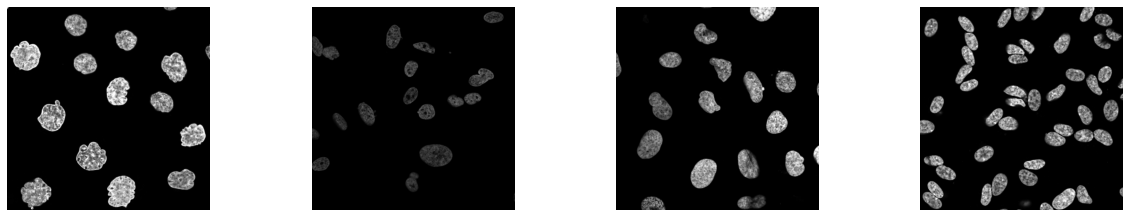

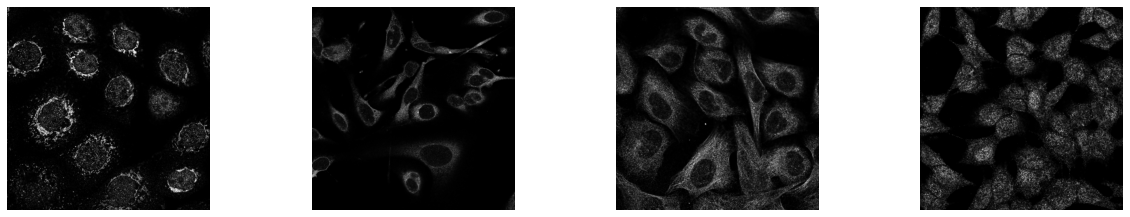

In [132]:
ims = image_loader(map_df.ID[1:5], 'blue')
fig = plt.figure(figsize=(20, 20))
for i in range(len(ims)):
    plt.subplot(4, 4, i + 1)
    plt.axis('off')
    plt.imshow(ims[i])
    plt.subplots_adjust(wspace = 0.5)
    
ims = image_loader(map_df.ID[1:5], 'green')
fig = plt.figure(figsize=(20, 20))
for i in range(len(ims)):
    plt.subplot(4, 4, i + 1)
    plt.axis('off')
    plt.imshow(ims[i])
    plt.subplots_adjust(wspace = 0.5)

# Step 4: Segmentation masks

Thankfully a user named tito has uploaded segmentation masks created with a cell segmentation model using pretrained U-Nets. The masks are in their original size, so we will have to perform some reszing in our pipeline. Lets have a look at what these look like.

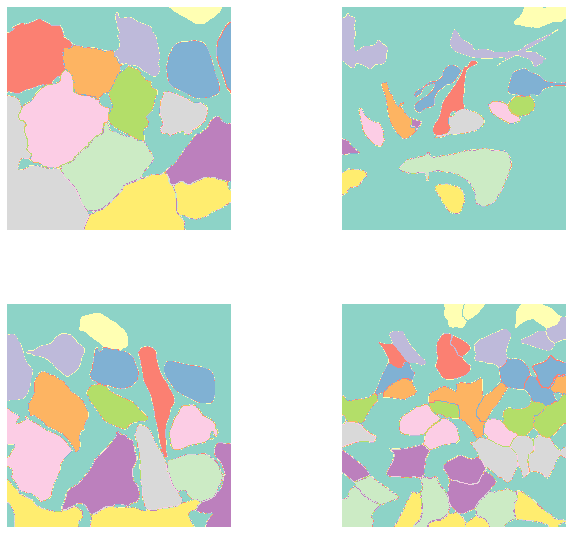

In [126]:
def mask_loader(file_ids):
    cont = []
    for i in file_ids:
        fp = ROOT3 + 'hpa_cell_mask/' + i + '.npz'
        cell_mask = np.load(fp)['arr_0']
        cont.append(cell_mask)
    return np.array(cont, dtype = object)


m = mask_loader(map_df.ID[1:5])
fig = plt.figure(figsize=(10, 10))
for i in range(len(m)):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(m[i], cmap='Set3')
    plt.subplots_adjust(wspace = 0.5)

# Ideas

- Use all the channels in a 4d convultional nn?
- How do I locate the cells?
- Need to research bounding boxes and object detection